In [1]:
import torch
from torch import nn

In [2]:
import torchvision
from torchvision import datasets

In [3]:
from torchvision import transforms

## Fashion MNIST

In [5]:
simple_transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor()
])

In [6]:
train_data = datasets.FashionMNIST(root="data", train=True, download=True, target_transform=None,
                                   transform=simple_transform)

test_data = datasets.FashionMNIST(root="data", train=False, download=True, target_transform=None,
                                   transform=simple_transform)

In [7]:
len(train_data), len(test_data)

(60000, 10000)

In [8]:
image, label = train_data[0]

In [9]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [10]:
class_to_idx = train_data.class_to_idx

## Visualizing Data

In [11]:
import plotly.express as px
import numpy as np

In [12]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [13]:
from typing import Union

In [14]:
def showImage(image: Union[torch.Tensor, np.array], label: int) -> None:
    """Show Image of Fashion MNIST set with Label

    :param image: Image data
    :type image: Union[torch.Tensor, np.array]

    :param label: Label id
    :type label: int
    """

    class_nm = ['T-shirt/top','Trouser','Pullover','Dress',
                'Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']

    if image.ndim == 3:
        image = image.squeeze()

    fig = px.imshow(image, color_continuous_scale='gray', labels=dict(x=f"{class_nm[label]}"))
    fig.update_layout(coloraxis_showscale=False)
    fig.update_xaxes(showticklabels=False)
    fig.update_yaxes(showticklabels=False)

    fig.show()

In [15]:
showImage(image, label)

In [16]:
def plotRandomImg(train_data: torchvision.datasets.mnist.FashionMNIST, grid_len=5, seed=42):
    """_summary_

    :param train_data: Total Training Data
    :type train_data: torchvision.datasets.mnist.FashionMNIST

    :param grid_len: Number of grid, defaults to 5. Tot images = grid_len * grid_len
    :type grid_len: int, optional
    """
    torch.manual_seed(seed=seed)

    rand_indexs = torch.randint(0, len(train_data), size=[grid_len*grid_len])

    fig = make_subplots(grid_len, grid_len)
    
    row_ind_start = 1

    class_nm = ['T-shirt/top','Trouser','Pullover','Dress',
                'Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']
    samp_ind = 0

    while row_ind_start <=grid_len:
        col_ind_start = 1
        while col_ind_start <= grid_len:
            img_data, label = train_data[rand_indexs[samp_ind]]
            single_fig = go.Figure(go.Heatmap(z=img_data.squeeze()))
            fig.add_trace(single_fig.data[0], row_ind_start, col_ind_start)
            fig.update_yaxes(autorange="reversed")
            fig.update_xaxes(title_text = f"{class_nm[label]}", row=row_ind_start, col=col_ind_start)
            col_ind_start +=1
            samp_ind += 1
        row_ind_start += 1

    fig.update_layout(height=1000, width=1200)
    fig.update_layout(coloraxis_showscale=False)

    return fig

In [17]:
plotRandomImg(train_data, seed=2122)

In [18]:
from torch.utils.data import DataLoader

In [19]:
BATCH_SIZE = 32

In [20]:
# Turn datasets into iterables (batches)
train_dataloader = DataLoader(train_data, # dataset to turn into iterable
    batch_size=BATCH_SIZE, # how many samples per batch? 
    shuffle=True # shuffle data every epoch?
)

test_dataloader = DataLoader(test_data,
    batch_size=BATCH_SIZE,
    shuffle=False # don't necessarily have to shuffle the testing data
)


In [21]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))

In [22]:
x = train_features_batch[0]

In [23]:
train_features_batch[0].shape

torch.Size([1, 64, 64])

In [24]:
from torch import nn

In [25]:
# Import accuracy metric
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc


In [26]:
# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss() # this is also called "criterion"/"cost function" in some places

## Coding for Training & Testing

In [27]:
from tqdm.auto import tqdm

/Users/niteshkumarsharma/Desktop/AI/PyTorch/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



In [28]:
device = "mps"

In [29]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    model.to(device)
    for batch, (X, y) in enumerate(data_loader):
        # Send data to device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1)) # Go from logits -> pred labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")



In [30]:
def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode(): 
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)
            
            # 1. Forward pass
            test_pred = model(X)
            
            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                y_pred=test_pred.argmax(dim=1) # Go from logits -> pred labels
            )
        
        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

In [31]:
# Move values to device
torch.manual_seed(42)
def eval_model(model: torch.nn.Module, 
               data_loader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               accuracy_fn, 
               device: torch.device = device):
    """Evaluates a given model on a given dataset.

    Args:
        model (torch.nn.Module): A PyTorch model capable of making predictions on data_loader.
        data_loader (torch.utils.data.DataLoader): The target dataset to predict on.
        loss_fn (torch.nn.Module): The loss function of model.
        accuracy_fn: An accuracy function to compare the models predictions to the truth labels.
        device (str, optional): Target device to compute on. Defaults to device.

    Returns:
        (dict): Results of model making predictions on data_loader.
    """
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to the target device
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
        
        # Scale loss and acc
        loss /= len(data_loader)
        acc /= len(data_loader)
    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}

## 1st CNN Model

In [37]:
class FashionMnistModelV2(nn.Module):
    """Tiny VGG Implmentation in PyTorch
    """

    def __init__(self, input_shape: int, hidden_units:int, output_shape:int):
        super(FashionMnistModelV2, self).__init__()

        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)          
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.classifer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units * 16 * 16,
                      out_features=output_shape)
        )

    def forward(self, x:torch.tensor):
        x = self.conv_block_1(x)
        # print(x.shape)

        x = self.conv_block_2(x)
        # print(x.shape)

        x = self.classifer(x)
        # print(x.shape)

        return x

In [38]:
torch.manual_seed(34)
model_cnn = FashionMnistModelV2(input_shape=1, hidden_units=10, output_shape=10)

In [39]:
random_img = torch.randn(size=(32,1,64,64))

In [40]:
# random_img.to(device)

In [41]:
random_img[0].shape

torch.Size([1, 64, 64])

In [42]:
model_cnn(random_img[0].unsqueeze(dim=0))

tensor([[-0.0280,  0.0598, -0.0305,  0.0043, -0.0088,  0.0125, -0.0298, -0.0221,
         -0.0134, -0.0107]], grad_fn=<AddmmBackward0>)

In [43]:
from torchsummary import summary

In [46]:
summary(model_cnn, input_size=(1,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 64, 64]             100
              ReLU-2           [-1, 10, 64, 64]               0
            Conv2d-3           [-1, 10, 64, 64]             910
              ReLU-4           [-1, 10, 64, 64]               0
         MaxPool2d-5           [-1, 10, 32, 32]               0
            Conv2d-6           [-1, 10, 32, 32]             910
              ReLU-7           [-1, 10, 32, 32]               0
            Conv2d-8           [-1, 10, 32, 32]             910
              ReLU-9           [-1, 10, 32, 32]               0
        MaxPool2d-10           [-1, 10, 16, 16]               0
          Flatten-11                 [-1, 2560]               0
           Linear-12                   [-1, 10]          25,610
Total params: 28,440
Trainable params: 28,440
Non-trainable params: 0
---------------------------------

In [47]:
optimizer = torch.optim.SGD(params=model_cnn.parameters(), lr=0.1)

In [48]:
epochs = 10
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader, 
        model=model_cnn, 
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device="mps"
    )
    test_step(data_loader=test_dataloader,
        model=model_cnn,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device="mps")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 0.55506 | Train accuracy: 80.08%


 10%|█         | 1/10 [00:16<02:27, 16.38s/it]

Test loss: 0.37467 | Test accuracy: 86.65%

Epoch: 1
---------
Train loss: 0.32922 | Train accuracy: 88.31%


 20%|██        | 2/10 [00:32<02:07, 15.99s/it]

Test loss: 0.34177 | Test accuracy: 87.80%

Epoch: 2
---------
Train loss: 0.29064 | Train accuracy: 89.52%


 30%|███       | 3/10 [00:47<01:50, 15.83s/it]

Test loss: 0.33220 | Test accuracy: 88.33%

Epoch: 3
---------
Train loss: 0.26606 | Train accuracy: 90.50%


 40%|████      | 4/10 [01:03<01:34, 15.77s/it]

Test loss: 0.31651 | Test accuracy: 88.84%

Epoch: 4
---------
Train loss: 0.25027 | Train accuracy: 91.00%


 50%|█████     | 5/10 [01:19<01:19, 15.96s/it]

Test loss: 0.29528 | Test accuracy: 89.65%

Epoch: 5
---------
Train loss: 0.23877 | Train accuracy: 91.43%


 60%|██████    | 6/10 [01:35<01:03, 15.87s/it]

Test loss: 0.30182 | Test accuracy: 89.01%

Epoch: 6
---------
Train loss: 0.22810 | Train accuracy: 91.76%


 70%|███████   | 7/10 [01:51<00:47, 15.83s/it]

Test loss: 0.32277 | Test accuracy: 88.80%

Epoch: 7
---------
Train loss: 0.22426 | Train accuracy: 91.97%


 80%|████████  | 8/10 [02:07<00:31, 15.91s/it]

Test loss: 0.28449 | Test accuracy: 90.21%

Epoch: 8
---------
Train loss: 0.21432 | Train accuracy: 92.38%


 90%|█████████ | 9/10 [02:23<00:16, 16.06s/it]

Test loss: 0.27281 | Test accuracy: 90.74%

Epoch: 9
---------
Train loss: 0.21101 | Train accuracy: 92.29%


100%|██████████| 10/10 [02:39<00:00, 15.97s/it]

Test loss: 0.28706 | Test accuracy: 89.83%



In [49]:
device

'mps'

In [50]:
model_cnn_results = eval_model(model=model_cnn, data_loader=test_dataloader,
                               loss_fn=loss_fn,
                               accuracy_fn=accuracy_fn,
                               device=device)

In [51]:
model_cnn_results

{'model_name': 'FashionMnistModelV2',
 'model_loss': 0.28706231713294983,
 'model_acc': 89.82627795527156}

In [45]:
# model_cnn.eval()
# with torch.inference_mode():
#     model_cnn(train_features_batch[0].to(device))

In [46]:
# train_features_batch.shape

In [52]:
def make_predictions(model: nn.Module, data: list, device: torch.device = device):
    """Make & Evaluate Random Predictions with the Best Model

    :param model: Train CNN Model
    :type model: nn.Module

    :param data: List of Input Tensors
    :type data: list

    :param device: _description_, defaults to device
    :type device: torch.device, optional
    """

    pred_probs = []

    # Setting Model on Eval Mode #
    model.eval()

    with torch.inference_mode():
        for sample in data:
            # Prepare Sample #
            sample = torch.unsqueeze(sample, dim=0).to(device)

            # Model Output(This would be raw logits)
            pred_logit = model(sample)

            # Get Prediction Probability (logit -> prediction Probabilty)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

            # Get Pred_Prob off GPU for furthure Calculations #
            pred_probs.append(pred_prob.cpu())

    return torch.stack(pred_probs)

In [53]:
import random
random.seed(42)

In [54]:
test_samples = []
test_labels = []

for sample, label in random.sample(list(test_data), k = 9):
    test_samples.append(sample)
    test_labels.append(label)

In [55]:
print(f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]} ({class_names[test_labels[0]]})")

Test sample image shape: torch.Size([1, 64, 64])
Test sample label: 5 (Sandal)


In [56]:
pred_probs = make_predictions(model=model_cnn, data=test_samples)

In [57]:
pred_probs.shape

torch.Size([9, 10])

In [58]:
pred_classes = pred_probs.argmax(dim=1)

In [59]:
test_labels, pred_classes

([5, 1, 7, 4, 3, 0, 4, 7, 1], tensor([5, 1, 7, 4, 3, 0, 4, 7, 1]))

In [60]:
import matplotlib.pyplot as plt

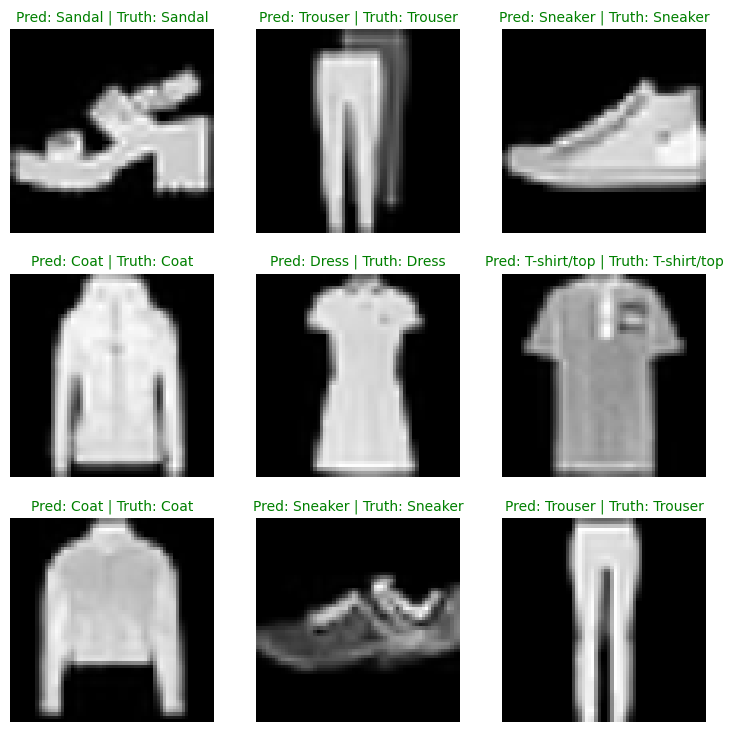

In [61]:
# Plot predictions
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  # Create a subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(sample.squeeze(), cmap="gray")

  # Find the prediction label (in text form, e.g. "Sandal")
  pred_label = class_names[pred_classes[i]]

  # Get the truth label (in text form, e.g. "T-shirt")
  truth_label = class_names[test_labels[i]] 

  # Create the title text of the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"
  
  # Check for equality and change title colour accordingly
  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g") # green text if correct
  else:
      plt.title(title_text, fontsize=10, c="r") # red text if wrong
  plt.axis(False);


## Plotting Confusion Matrix!

In [62]:
y_preds = []
model_cnn.eval()
with torch.inference_mode():
    for X, y in tqdm(test_dataloader, desc="Making Preds"):
        X, y = X.to(device), y.to(device)

        y_logit = model_cnn(X)

        y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)

        y_preds.append(y_pred.cpu())

Making Preds: 100%|██████████| 313/313 [00:01<00:00, 241.46it/s]


In [63]:
y_preds[2]

tensor([1, 1, 3, 3, 7, 8, 7, 0, 2, 6, 2, 3, 1, 2, 8, 4, 1, 8, 5, 9, 5, 0, 3, 2,
        0, 6, 5, 3, 6, 7, 1, 8])

In [64]:
y_pred_tensor = torch.cat(y_preds)

In [65]:
y_pred_tensor.shape

torch.Size([10000])

In [66]:
train_features_batch.shape

torch.Size([32, 1, 64, 64])

In [67]:
model_cnn.eval()
with torch.inference_mode():
     model_cnn(X)

In [68]:
import torchmetrics

In [69]:
y_pred_tensor.shape

torch.Size([10000])

In [70]:
test_data.targets.shape

torch.Size([10000])

In [71]:
y_pred_tensor[555]

tensor(1)

In [72]:
bool_tensor = y_pred_tensor == test_data.targets

In [73]:
wrong_preds_id = y_pred_tensor != test_data.targets

## Analysis Where Model is Performing Very Poorly


In [74]:
test_data_wrng_pred = test_data.data[wrong_preds_id]
test_wrong_gt = test_data.targets[wrong_preds_id]
wrong_pred = y_pred_tensor[wrong_preds_id]

In [75]:
wrong_pred[555]

tensor(6)

In [76]:
test_data_wrng_pred = test_data_wrng_pred.float()

In [77]:
test_data_wrng_pred.device

device(type='cpu')

In [78]:
idx = 107
showImage(test_data_wrng_pred[idx].cpu(), test_wrong_gt[idx])
print(class_names[wrong_pred[idx]])

Coat


In [79]:
import mlxtend

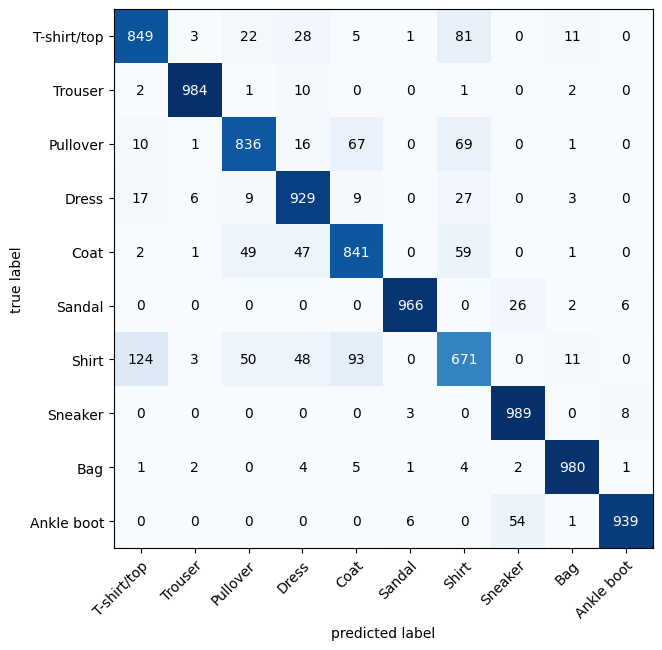

In [80]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor, target=test_data.targets)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy 
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10, 7)
);

In [ ]:
## Saving the Model

In [89]:
from pathlib import Path

# Create Model directory Path 
MODEL_PATH = Path("models")

In [90]:
MODEL_PATH.mkdir(parents=True, exist_ok=True)

In [91]:
MODEL_NAME = "TINY_VGG.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

In [92]:
torch.save(obj=model_cnn.state_dict(), f=MODEL_SAVE_PATH)

In [93]:
## Loading Model
Model_CNN_2 = FashionMnistModelV2(input_shape=1, 
                                  hidden_units=10,
                                  output_shape=10)

In [94]:
Model_CNN_2.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [95]:
Model_CNN_2.to(device)

FashionMnistModelV2(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifer): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [96]:
# Evaluate Loaded Model

In [97]:
model_cnn_results

{'model_name': 'FashionMnistModelV2',
 'model_loss': 0.28513386845588684,
 'model_acc': 89.82627795527156}

In [98]:
torch.manual_seed(42)

loaded_model_2_results = eval_model(Model_CNN_2, test_dataloader, loss_fn, accuracy_fn)